#Social Sorting su grafo PowerLaw

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random as rd

#Parametri di esecuzioni
#Peso tra 0 e 1 sull'ifluenza dei nodi non membri della mia tribu
SOCIAL_SORTING_WEIGHT = 0.5
"""Numero nodi nel grafo"""
NODI = 2500
"""Numero di archi per nodo"""
ARCHI_PER_NODO = 4
"""Probabilità di ricevere un nuovo arco incidente ogni volta che è aggiunto un nodo"""
PROB_ARCHI_INC = 0.9
"""Estremi intervallo dell'ideologia"""
MAX_LV_CONVINCIMENTO=500
"""Ofsett dell'ideologia iniziale per entrambe le tribu dal valore di split idea"""
INTERVALLO_LV_CONVINCIMENTO_INIZIALE =50
"""Intervallo nel quale i nodi sono considerati moderati, dunque mostrati in verde"""
INTERVALLO_MODERATI = 50
"""Intervallo di inizializzazzione della forza di persuasione di un nodo"""
FORZA_PERSUASIONE = [1,2]
"""Numero di iterazioni di algoritmo di cambio idea prima di stampa del grafo"""
ITERATIONS =  1000

Funzioni e costanti di esecuzione

In [ ]:
#funzione per aggiustare un valore nell'intervallo [0-MAX_IDEA]
def aggiusta_valore(v):
  if v > MAX_LV_CONVINCIMENTO:
    v = MAX_LV_CONVINCIMENTO
  elif v < 0:
    v = 0
  return v / MAX_LV_CONVINCIMENTO

#controllo se è un moderato nell'ideologia
def is_moderate(livello_convincimento):
  if livello_convincimento <= INTERVALLO_MODERATI:
      return True
  else:
    return False

"""
Funzione per creare una color map per colorare i nodi, essi sono identificati posizionalmente.
E' necessario creare una copia di ciscun attributo idea di ogni nodo altrimenti la normalizzazzione
in 0 1 per la scala rgb andrebbe a modificare i valori nei nodi del grafo stesso
"""
def create_color_map(G):
  #Copia valori nei nodi
  color_map = []
  for n in G.nodes():
    #prendo il valore dell'idea, intero
    livello_convincimento = G.nodes[n]["value"]["livello_convincimento"]

    colore = 0.5 + aggiusta_valore(livello_convincimento) / 2

    if colore >= 1 :
      colore = 1

    if G.nodes[n]["value"]["tribe"] == "A":
      nuovo = [colore,0,0]
    else:
      nuovo = [0,0, colore]

    color_map.append(nuovo)

  return color_map

#Cambiamento Ideologia secondo modello Nowak e Lewenstein
#restiuisce di quanto cambiare il valore dell'ideologia del nodo
#Ricorda l'assunzione che 0 = massimo ideologia Blu mentre MAX_IDEA = massimo ideologia rossa
def cambio_ideologia_NL(G,nodo,vicino):
  #Mi faccio influenzare dall'idea del vicino, se è uguale alla mia il cambio idea è nullo
  incremento = G.nodes[vicino]["value"]["force"]

  if G.nodes[nodo]["value"]["tribe"]  == G.nodes[vicino]["value"]["tribe"]:
    return incremento
  else:
    return -incremento

#Divisione del grafo in tre liste in base all'ideologia
def communities_for_idea(G):
  #Inizializzazzione liste
  pro = []
  contro = []

  for n in G.nodes():
    node = copy.deepcopy(n)

    if G.nodes[n]["value"]["tribe"] == "a":
      pro.append(node)
    else:
      contro.append(node)

  return [pro,contro]

#funzione per disegnare il grafo diviso per tribu
def disegna_by_idea(G,color_map):

  #Divisione comunity in base a idea
  communities = communities_for_idea(G)

  # Compute positions for the node clusters as if they were themselves nodes in a
  # supergraph using a larger scale factor
  supergraph = nx.cycle_graph(len(communities))
  superpos = nx.spring_layout(G, scale=5, seed=429)

  # Use the "supernode" positions as the center of each node cluster
  centers = list(superpos.values())
  pos = {}
  for center, comm in zip(centers, communities):
      pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

  nx.draw_networkx_nodes(G,
                         pos=pos,
                         node_color=color_map,
                         node_size=10)

  nx.draw_networkx_edges(G, pos=pos)

  plt.tight_layout()
  plt.show()

#funione inizializzare i nodi in due tribu distinte con valore ideologia iniziale medio e forza di persuasione diversa
def set_nodes(G):
  for n in G.nodes():
    livello_convincimento = rd.randint(0,INTERVALLO_LV_CONVINCIMENTO_INIZIALE)
    if(rd.randint(0,1)):
      tribe = "A"
    else:
      tribe = "B"
    #generazione idea
    force = rd.randint(FORZA_PERSUASIONE[0],FORZA_PERSUASIONE[1])
    #creazione nodi con idea casuale
    nuovo = {"tribe":tribe, "livello_convincimento":livello_convincimento, "force":force}
    G.nodes[n]["value"] = copy.deepcopy(nuovo)


"""
Funzione per il calcolo di communità di nodi in base a misure di comunità
"""
def calcola_pos(G):
  #calcolo comunità, restituisce un generatore che andrà convertito in una lista per calcolare
  #le super posizioni del grafo
  communities = nx.community.fast_label_propagation_communities(G)
  com = []
  for c in communities:
    com.append(list(c))
  communities = com

  # Compute positions for the node clusters as if they were themselves nodes in a
  # supergraph using a larger scale factor
  supergraph = nx.cycle_graph(len(communities))
  superpos = nx.spring_layout(G, scale=5, seed=429)

  # Use the "supernode" positions as the center of each node cluster
  centers = list(superpos.values())
  pos = {}
  for center, comm in zip(centers, communities):
      pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))

  return pos

"""
Metodo per disegnare il grafo la cui posizione è stata calcolata esternamente
"""
def disegna_per_comuninity(G,color_map,pos):
  #Divisione comunity in base a idea
  #communities = communities_for_idea(G)
  nx.draw_networkx_nodes(G,pos=pos,node_color=color_map,node_size=10)

  nx.draw_networkx_edges(G, pos=pos)

  plt.tight_layout()
  plt.show()

def disegna_power_law(G,color_map):
  pos = nx.pydot_layout(G)
  """for i in range(0,50):
    for j in range(0,50):
      pos.append((i,j))"""
  nx.draw(
    G,
    pos,
    node_color=color_map,
    cmap=plt.cm.plasma,
    node_size=50
  )

In [ ]:
#Creazione grafo a partire da generatori di networkx
OG = nx.barabasi_albert_graph(NODI,ARCHI_PER_NODO)

#Popolamento nodi con valori tribu, idea, e forza inzile
set_nodes(OG)
#Creazione copia del grafo per esecuzione in Social Sorting true
G = copy.deepcopy(OG)
GS = copy.deepcopy(G)

#Esecuzione e raccolta dati

In [ ]:
#apllichiamo un algoritmo di convergenza sull'idea, senza che venga applicata alcun tipo di discriminazione.
#itero per avere una convergenza
def interazioni (G,numero_interazioni,statistics):
  for i in range(0,numero_interazioni):
    spinta_idee = {}
    #inizializzazione un array di copie delle idee dei nodi per calcolare le nuove idee
    #prima calcolo il nuovo stato per ogni nodo e solo dopo lo applico così che l'aggiornamento avvenga
    #per tutti i nodi in base allo stato degli altri all'istante t
    for n in G.nodes():
      spinta_idee[n] = 0

    for n in G.nodes:
      #Estraggo i vicini del nodo n
      tribe_n = G.nodes[n]["value"]["tribe"]
      for vicino in nx.neighbors(G, n):
        if (G.nodes[vicino]["value"]["tribe"] != tribe_n) and SOCIAL_SORTING:
          spinta_idee[n] += cambio_ideologia_NL(G,n,vicino) * SOCIAL_SORTING_WEIGHT
        else:
          spinta_idee[n] += cambio_ideologia_NL(G,n,vicino)

    #RACCOLTA DATI
    avg_a = 0
    count_a = 0
    avg_b = 0
    count_b = 0
    max_idea_a = 0
    max_idea_b = 0
    num_moderati = 0
    global_a = 0
    global_b = 0
    change_tribe = 0
    #Per la raccolta dati misuto l'intensità dell'idea di ogni tribu, non tanto il suo valore assoluto
    for n in G.nodes():
      if G.nodes[n]["value"]["tribe"] == "A":
        count_a += 1
        avg_a += (G.nodes[n]["value"]["livello_convincimento"])
        global_a += (G.nodes[n]["value"]["livello_convincimento"])
      #caso tribu b
      else:
        count_b += 1
        avg_b += (G.nodes[n]["value"]["livello_convincimento"])
        global_b += (G.nodes[n]["value"]["livello_convincimento"])
      #controllo moderato
      if is_moderate(G.nodes[n]["value"]["livello_convincimento"]):
        num_moderati += 1

    #appendo le statistiche all'iterazioe i
    if count_a != 0:
      statistics["tribe_a_avg"].append(avg_a/count_a)
    else:
      statistics["tribe_a_avg"].append(0)

    if count_b != 0:
      statistics["tribe_b_avg"].append(avg_b/count_b)
    else:
      statistics["tribe_b_avg"].append(0)

    statistics["num_moderati"].append(num_moderati)
    statistics["num_tribe_a"].append(count_a)
    statistics["num_tribe_b"].append(count_b)
    statistics["global_a"].append(global_a)
    statistics["global_b"].append(global_b)
    #FINE RACCOLTA DATI

    #aggiornamento di stato del grafo
    for n in G.nodes():

      #Aggiorni il livello di convincimento del nodo con la somma delle forze di persuasione dei vicini della stessa tribu e
      #meno la somma delle forze di persuasione dei vicini di tribu opposta

      G.nodes[n]["value"]["livello_convincimento"] += spinta_idee[n]
      #Se il mio livello di convincimento supera il massimo di intensità la riassetto
      if G.nodes[n]["value"]["livello_convincimento"] >= MAX_LV_CONVINCIMENTO:
        G.nodes[n]["value"]["livello_convincimento"] = MAX_LV_CONVINCIMENTO
      #Se il mio livello di convincimento scende sotto 0, cambio tribu
      elif G.nodes[n]["value"]["livello_convincimento"] <= 0:
        #Resetto l'idea del nodo a 0
        G.nodes[n]["value"]["livello_convincimento"] = 0
        change_tribe += 1
        if G.nodes[n]["value"]["tribe"] == "A":
          G.nodes[n]["value"]["tribe"] = "B"
        else:
           G.nodes[n]["value"]["tribe"] = "A"

    statistics["change_tribe"].append(change_tribe)

In [ ]:
"""
Nel dizionario sono contenuti i nomi delle colonne che andranno nei dataset di raccolta dei dati e associati ai nomi delle chiavi dentro
gli oggetti che raccoglieranno dati durante l'esecuzione.
In questo punto si possono aggiungere nuovi campi colonne sia al dataset che gli oggetti necesarie a roccglierne i valori.
Se non viene rispecificato in seguito durante il preprocessing i dati saranno normalizzati
"""
dict_colonna_chiave = {
    "avg_livello_convincimento_a" : "tribe_a_avg",
    "avg_livello_convincimento_b" : "tribe_b_avg",
    "num_moderati" : "num_moderati",
    "num_tribe_a" : "num_tribe_a",
    "num_tribe_b" : "num_tribe_b",
    "total_livello_convincimento_a" : "global_a",
    "total_livello_convincimento_b" : "global_b",
    "num_change_of_tribe" : "change_tribe"
}

prototipo_stats = {}
for v in dict_colonna_chiave.values():
  prototipo_stats[v] = []

Rieseguire più volte questi due blocchi per poter vedere gradualmente il cambiamento nel grafo

In [ ]:
#Esecuzione in Social Sorting False
SOCIAL_SORTING = False
statistics_SSF = copy.deepcopy(prototipo_stats)
interazioni(G,ITERATIONS,statistics_SSF)

In [ ]:
#Esecuzione in Social Sorting True
SOCIAL_SORTING = True
statistics_SST = copy.deepcopy(prototipo_stats)
interazioni(GS,ITERATIONS,statistics_SST)

#Valutazione delle statistiche raccolte in esecuzione

In [ ]:
node_degree = [[n,G.degree(n)] for n in G.nodes() ]

def fnsort(a):
  return a[1]
node_degree.sort(key=fnsort, reverse=True)

livelli = []
livello = []
start = node_degree[0][1]

for nd in node_degree:
  if nd[1] == start:
    livello.append(nd[0])
  else:
    livelli.append(livello)
    livello = []
    livello.append(nd[0])
    start = nd[1]

appiattita = []

for l in livelli:
  for e in l:
    appiattita.append(e)

last = []
for dimenticato in G.nodes():
  if dimenticato not in appiattita:
    last.append(dimenticato)

livelli.append(last)


Grafo di partenza


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


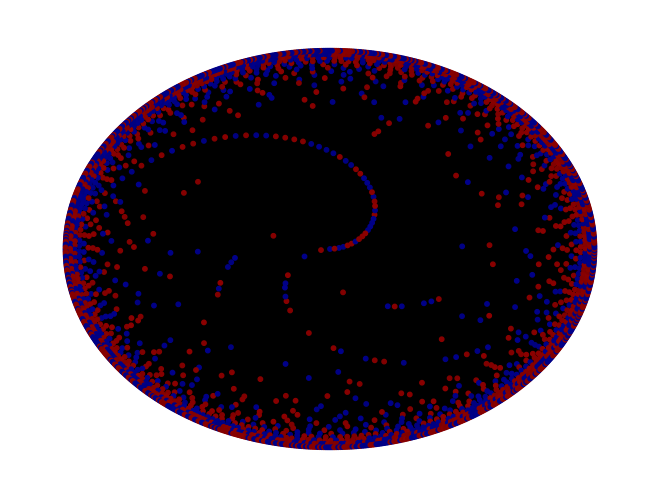

In [ ]:
print("Grafo di partenza")

def disegna_power_law(G,color_map):
  #trova nodo con massimo numero gradi
  nd = 0
  deg = 0
  for nodo in G.nodes():
    if G.degree(nodo) > deg:
      deg =  G.degree(nodo)
      nd = nodo

  pos = nx.shell_layout(G,nlist=livelli)
  """for i in range(0,50):
    for j in range(0,50):
      pos.append((i,j))"""
  nx.draw(
    G,
    pos,
    node_color=color_map,
    cmap=plt.cm.plasma,
    node_size=10
  )

color_map = create_color_map(OG)
#disegna_by_idea(OG, color_map)
#pos = calcola_pos(OG)
#disegna_per_comuninity(OG, color_map, pos)
disegna_power_law(G,color_map)

Grafo dopo  1000  passi - SOCIAL SORTING disattivato


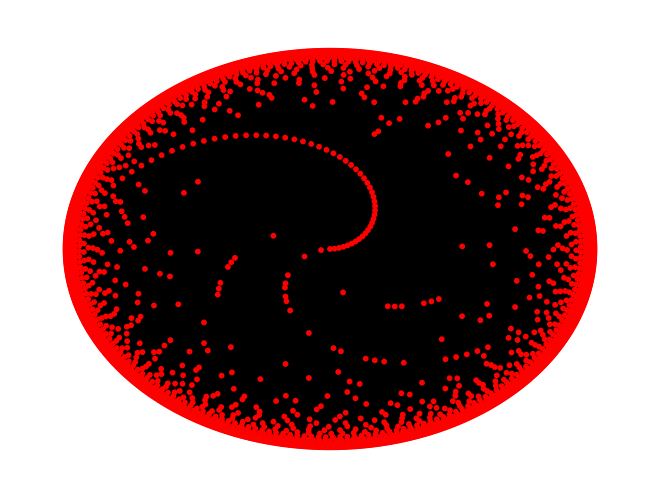

In [ ]:
#nuova colormap e disegno
print("Grafo dopo ", ITERATIONS," passi - SOCIAL SORTING disattivato")
color_map = create_color_map(G)
#disegna_by_idea(G, color_map)
#disegna_per_comuninity(OG, color_map, pos)
disegna_power_law(G,color_map)

Grafo dopo  1000  passi - SOCIAL SORTING attivato


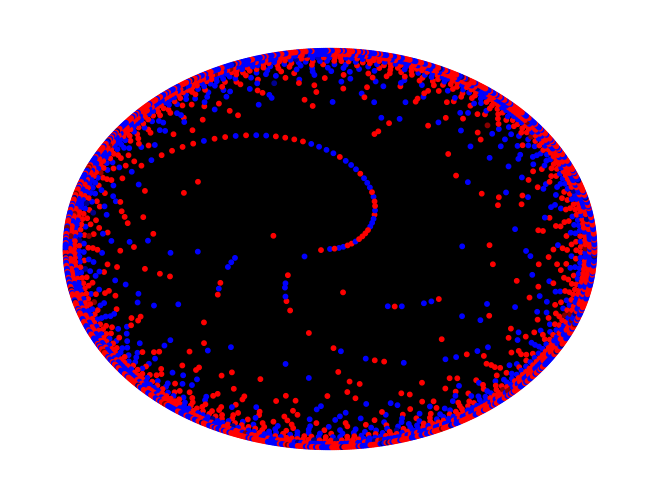

In [ ]:
print("Grafo dopo ", ITERATIONS," passi - SOCIAL SORTING attivato")
color_map = create_color_map(GS)
#disegna_by_idea(GS, color_map)
#disegna_per_comuninity(OG, color_map, pos)
disegna_power_law(G,color_map)

In [ ]:
import pandas as pd
clustering_coefficient = nx.average_clustering(G)
caracteristic_length = nx.average_shortest_path_length(G)
#Dizionario contentente le colonne associate alle chiavi nell'oggetto che raccoglie le statistiche

#popolo gli oggetti che andranno a creare il dataset
stat_SSF = {}
stat_SST = {}
for k in dict_colonna_chiave:
  stat_SSF[k] = statistics_SSF[dict_colonna_chiave[k]]
  stat_SST[k] = statistics_SST[dict_colonna_chiave[k]]

#Due datasetDati per le due esecuzioni
dataSSF = pd.DataFrame(data=stat_SSF)
dataSST = pd.DataFrame(data=stat_SST)

dataSSF.head()

,avg_livello_convincimento_a,avg_livello_convincimento_b,num_moderati,num_tribe_a,num_tribe_b,total_livello_convincimento_a,total_livello_convincimento_b,num_change_of_tribe
0,24.736006,25.691002,2500,1322,1178,32701,30264,98
1,25.436747,25.359215,2416,1328,1172,33780,29721,100
2,27.341829,25.328473,2316,1334,1166,36474,29533,86
3,29.749632,26.078809,2209,1358,1142,40400,29782,68
4,32.944687,26.873890,2101,1374,1126,45266,30260,75


In [ ]:
print("clustering_coefficient: ",clustering_coefficient)
print("caracteristic_length: ",caracteristic_length)

clustering_coefficient:  0.01862925287322239
caracteristic_length:  3.478205042016807


In [ ]:
#Creazione distanza ideologie
#normalizzazzione_dati
"""
    "avg_livello_convincimento_a",
    "avg_livello_convincimento_b",
    "num_moderati",
    "num_tribe_a",
    "num_tribe_b",
    "total_livello_convincimento_a",
    "total_livello_convincimento_b",
"""
def normalizza_dati(dataset):
  dataset["distanza_tribu"] = abs(dataset["avg_livello_convincimento_a"] + dataset["avg_livello_convincimento_b"])

dataSSF_norm = dataSSF.copy()
dataSST_norm = dataSST.copy()

normalizza_dati(dataSSF_norm)
normalizza_dati(dataSST_norm)

dataSST_norm.head(10)

,avg_livello_convincimento_a,avg_livello_convincimento_b,num_moderati,num_tribe_a,num_tribe_b,total_livello_convincimento_a,total_livello_convincimento_b,num_change_of_tribe,distanza_tribu
0,24.736006,25.691002,2500,1322,1178,32701.0,30264.0,28,50.427008
1,28.195537,28.209677,2319,1322,1178,37274.5,33231.0,17,56.405214
2,31.818972,30.969839,2170,1323,1177,42096.5,36451.5,8,62.788811
3,35.892776,33.556118,2004,1315,1185,47199.0,39764.0,18,69.448894
4,39.769962,36.532068,1851,1315,1185,52297.5,43290.5,14,76.302029
5,43.772624,39.607173,1711,1315,1185,57561.0,46934.5,21,83.379797
6,47.629728,43.067063,1592,1322,1178,62966.5,50733.0,17,90.696791
7,51.789375,46.585251,1466,1327,1173,68724.5,54644.5,11,98.374626
8,56.414902,49.775042,1371,1322,1178,74580.5,58635.0,14,106.189944
9,60.684012,53.482538,1248,1326,1174,80467.0,62788.5,15,114.166550


In [ ]:
dataSSF_norm.tail(10)

,avg_livello_convincimento_a,avg_livello_convincimento_b,num_moderati,num_tribe_a,num_tribe_b,total_livello_convincimento_a,total_livello_convincimento_b,num_change_of_tribe,distanza_tribu
990,500.0,0.0,0,2500,0,1250000,0,0,500.0
991,500.0,0.0,0,2500,0,1250000,0,0,500.0
992,500.0,0.0,0,2500,0,1250000,0,0,500.0
993,500.0,0.0,0,2500,0,1250000,0,0,500.0
994,500.0,0.0,0,2500,0,1250000,0,0,500.0
995,500.0,0.0,0,2500,0,1250000,0,0,500.0
996,500.0,0.0,0,2500,0,1250000,0,0,500.0
997,500.0,0.0,0,2500,0,1250000,0,0,500.0
998,500.0,0.0,0,2500,0,1250000,0,0,500.0
999,500.0,0.0,0,2500,0,1250000,0,0,500.0


Media Ideologie senza Social Sorting


<Axes: >

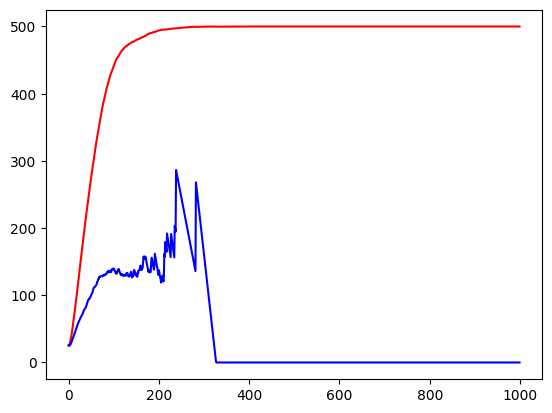

In [ ]:
print("Media Ideologie senza Social Sorting")
dataSSF_norm["avg_livello_convincimento_a"].plot.line(color="red")
dataSSF_norm["avg_livello_convincimento_b"].plot.line(color="blue")

Media Ideologie con Social Sorting


<Axes: >

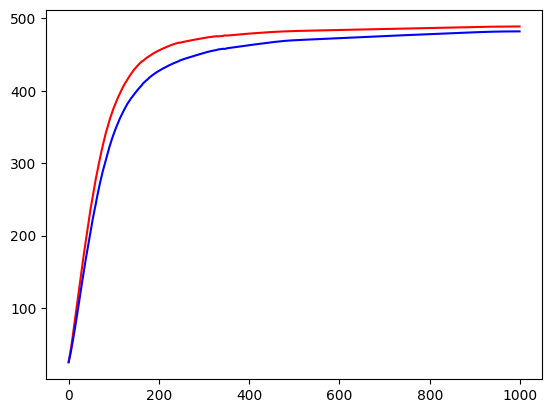

In [ ]:
#Andamento nodi
print("Media Ideologie con Social Sorting")
dataSST_norm["avg_livello_convincimento_a"].plot.line(color="red")
dataSST_norm["avg_livello_convincimento_b"].plot.line(color="blue")

Numero nodi moderati rispetto al totale - SSF vs SST


<Axes: >

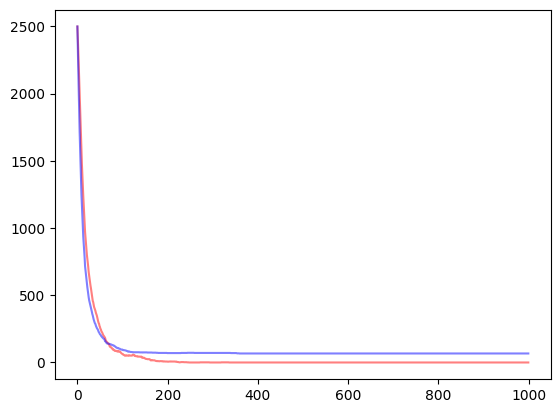

In [ ]:
print("Numero nodi moderati rispetto al totale - SSF vs SST")
dataSSF_norm["num_moderati"].plot.line(alpha = 0.5, color="red")
dataSST_norm["num_moderati"].plot.line(alpha = 0.5, color="blue")

Numero membri tribu - Social Sorting False 


<Axes: >

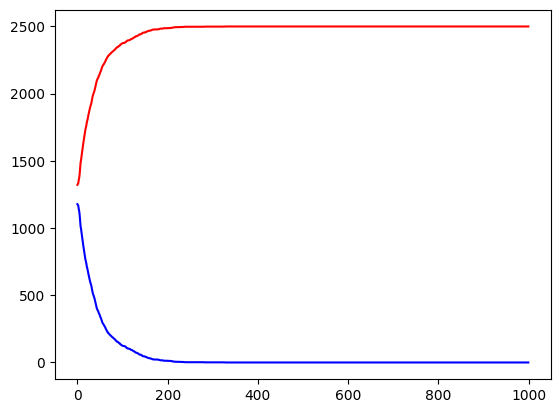

In [ ]:
print("Numero membri tribu - Social Sorting False ")
dataSSF_norm["num_tribe_a"].plot.line(color="red")
dataSSF_norm["num_tribe_b"].plot.line(color="blue")

Numero membri tribu - Social Sorting True 


<Axes: >

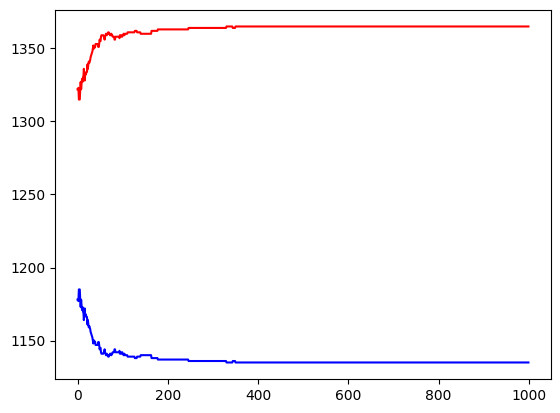

In [ ]:
print("Numero membri tribu - Social Sorting True ")
dataSST_norm["num_tribe_a"].plot.line( color="red")
dataSST_norm["num_tribe_b"].plot.line( color="blue")

Distanza tra l'ideologia media delle tribu


<Axes: >

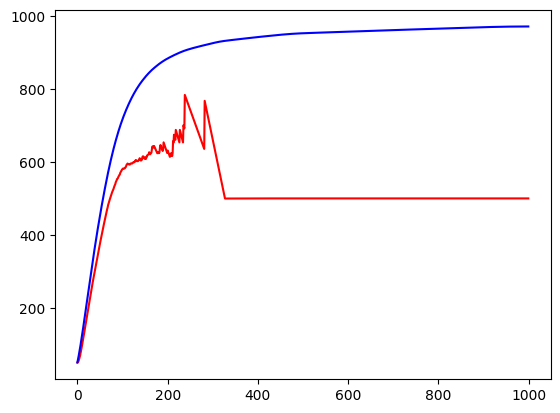

In [ ]:
print("Distanza tra l'ideologia media delle tribu")
dataSSF_norm["distanza_tribu"].plot.line(color="red")
dataSST_norm["distanza_tribu"].plot.line(color="blue")

Valore complessivo del grado di convicimento per tribu - SS False


<Axes: >

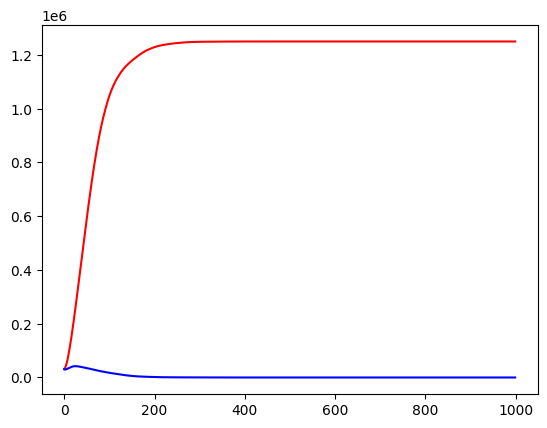

In [ ]:
print("Valore complessivo del grado di convicimento per tribu - SS False")
dataSSF_norm["total_livello_convincimento_a"].plot.line(color="red")
dataSSF_norm["total_livello_convincimento_b"].plot.line(color="blue")

Valore complessivo del grado di convicimento per tribu - SS True


<Axes: >

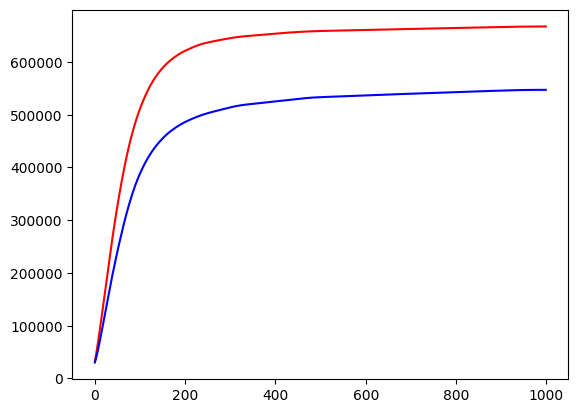

In [ ]:
print("Valore complessivo del grado di convicimento per tribu - SS True")
dataSST_norm["total_livello_convincimento_a"].plot.line(color="red")
dataSST_norm["total_livello_convincimento_b"].plot.line(color="blue")

Numero di cambi di tribu tra le due esecuzioni


<Axes: >

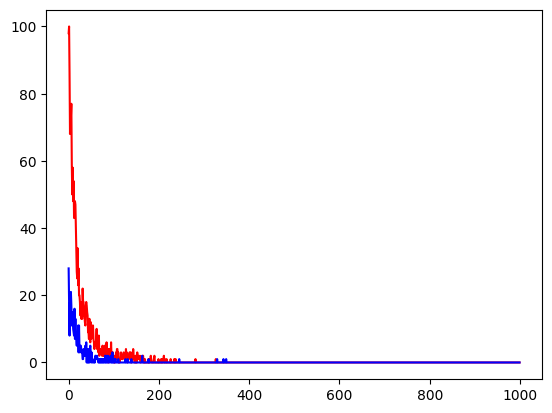

In [ ]:
print("Numero di cambi di tribu tra le due esecuzioni")
dataSSF_norm["num_change_of_tribe"].plot.line(color="red")
dataSST_norm["num_change_of_tribe"].plot.line(color="blue")